# P6 Computational Vision

**Important:** Read the file `README.md` before start coding.

<div class = "alert alert-info" style = "border-radius:10px;border-width:3px;border-color:darkblue;font-family:Verdana,sans-serif;font-size:16px;">

**Delivery**

<ol>
Requirements to fulfill:
<ul>
    <li>  Answer the questions introduced in the exercises.
    <li>  The implemented code should be,<br>
        - free of errors (Run All before delivery and check for possible errors)<br>
        - optimized ( e.g. do not use 'for' instruction when indexing numpy arrays)<br>
        - readable  ( e.g. avoiding the implementation of more than 2 loops within a line)<br>
        - commented and with descriptions      
    <li> The deliverable must be a file named P6_Student1_Student2.zip that includes:
    <ul>
        <li> The notebook P6_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.
         <li> All the images used in this notebook.
    </ul>

</ul>

 **Deadline (Campus Virtual): November 11th, 23:00 h** 


</ol>
</div>

## Face recognition

The main topics of this notebook are:

- Face recognition problem
- Eigenfaces

We work with the code of a face recognition algorithm using sckit-learn (Source [here](https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html#sphx-glr-auto-examples-applications-plot-face-recognition-py)) and an out-of-the-box dataset by the University of Massachusetts called Labeled Faces in the Wild ([LFW](http://vis-www.cs.umass.edu/lfw/)). Scikit-learn can automatically load the dataset in the correct format. Read the code and do the exercises below.


In [1]:
from time import time
import logging
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC

In [2]:
# #############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print(f'Total dataset size:')
print(f'n_samples:  {n_samples}')
print(f'n_features: {n_features}')
print(f'n_classes:  {n_classes}')

Total dataset size:
n_samples:  1288
n_features: 1850
n_classes:  7


In [3]:
# #############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [4]:
# #############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 100

print(f'Extracting the top {n_components} eigenfaces from {X_train.shape[0]} faces.')
ts = time()
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)
print(f'- Done in {time() - ts:.3f}s\n')

eigenfaces = pca.components_.reshape((n_components, h, w))

print('Projecting the input data on the eigenfaces orthonormal basis')
ts = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(f'- Done in {time() - ts:.3f}s')

Extracting the top 100 eigenfaces from 966 faces.
- Done in 0.155s

Projecting the input data on the eigenfaces orthonormal basis
- Done in 0.016s


In [5]:
# #############################################################################
# Train a SVM classification model

print('Fitting the classifier to the training set')

ts = time()
param_grid = {
    'C': [1e3, 5e3, 1e4, 5e4, 1e5],
    'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]
}

clf = GridSearchCV(
    SVC(kernel='rbf', class_weight='balanced'),
    param_grid=param_grid, cv=5, iid=False)

clf = clf.fit(X_train_pca, y_train)

print(f'- Done in {time() - ts:.3f}')
print('Best estimator found by grid search:')
print(clf.best_estimator_)

Fitting the classifier to the training set
- Done in 27.948
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [6]:
# #############################################################################
# Quantitative evaluation of the model quality on the test set

print('Predicting people\'s names on the test set')

ts = time()
y_pred = clf.predict(X_test_pca)

print(f'- Done in {time() - ts}')

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
- Done in 0.035839080810546875
                   precision    recall  f1-score   support

     Ariel Sharon       0.67      0.62      0.64        13
     Colin Powell       0.81      0.92      0.86        60
  Donald Rumsfeld       0.81      0.63      0.71        27
    George W Bush       0.88      0.95      0.91       146
Gerhard Schroeder       0.91      0.84      0.87        25
      Hugo Chavez       0.91      0.67      0.77        15
       Tony Blair       0.93      0.75      0.83        36

        micro avg       0.86      0.86      0.86       322
        macro avg       0.85      0.77      0.80       322
     weighted avg       0.86      0.86      0.86       322

[[  8   1   2   2   0   0   0]
 [  0  55   0   4   0   1   0]
 [  2   2  17   6   0   0   0]
 [  1   5   1 139   0   0   0]
 [  0   1   0   2  21   0   1]
 [  0   3   0   0   1  10   1]
 [  1   1   1   5   1   0  27]]


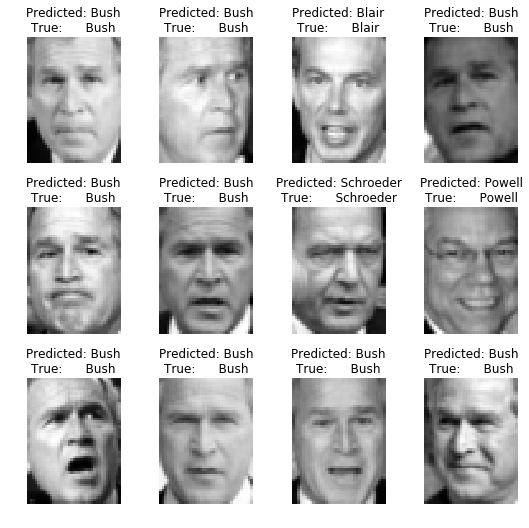

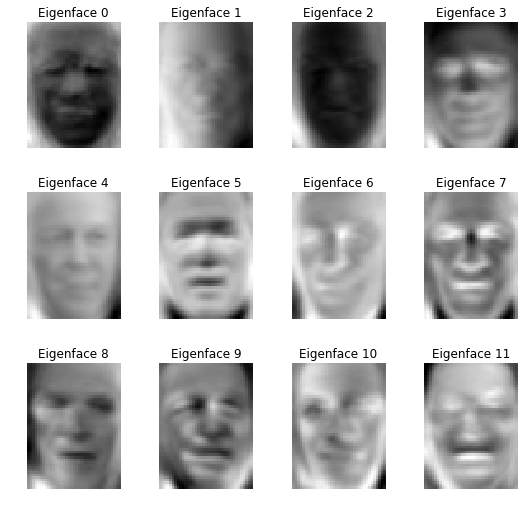

In [7]:
# #############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.axis('off')


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return f'Predicted: {pred_name}\nTrue:      {true_name}'


prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)


# plot the gallery of the most significative eigenfaces

eigenface_titles = [f'Eigenface {i}' for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

**Exercise 1:**

Show the total percentage of variance explained by the selected components of the PCA.

Variance explained with 100 components = 0.9283145070075989


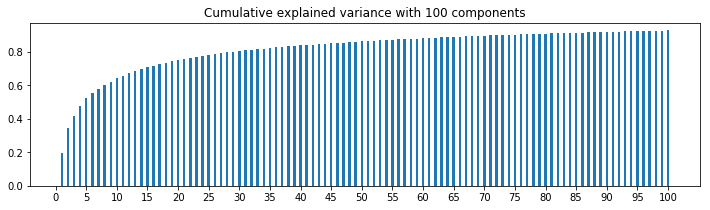

In [8]:
var_explained = pca.explained_variance_ratio_.cumsum()
print(f'Variance explained with {pca.n_components} components = {var_explained[-1]}')

plt.figure(figsize=(12, 3))
plt.bar(list(range(1, 101)), var_explained, width=0.4)
plt.title(f'Cumulative explained variance with {pca.n_components} components')
plt.xticks(list(range(0, 101, 5)))
plt.show()

<div class = "alert alert-info" style = "background-color:Wheat;border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;">

`explained_variance_ratio_` returns the percent of variance explained by each component. Performing a cumulative sum the last component (100th) has the variance explained by all of them.

</div>

**Exercise 2** 

- Explain all the measures showed in the classification report.
- Discuss the obtained classification results, the quantitative as well as the qualitative results.
- Comment the showed eigenfaces.

<div class = "alert alert-info" style = "background-color:Wheat;border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;">

**Report Measures**

Recalling the structure of a confusion matrix
<table style="border: 1px solid black">
    <tr>
        <td style="border-right: solid 1px black"></td>
        <td colspan="2">Predicted</td>
    </tr>
    <tr>
        <td rowspan="2" style="border-right: solid 1px black; border-top: solid 1px black">Actual</td>
        <td style="border-right: solid 1px black; border-top: solid 1px black">True Positives (TP)</td>
        <td style="border-right: solid 1px black; border-top: solid 1px black">False Positives (FP)</td>
    </tr>
    <tr>
        <td style="border-right: solid 1px black; border-top: solid 1px black">False Negatives (FN)</td>
        <td style="border-right: solid 1px black; border-top: solid 1px black">True Negatives (TN)</td>
    </tr>
</table>
    
`classification_report` builds a metric summary including 4 different metrics:
- Precision: Percentage of the results which are relevant. Ratio of _TP / (TP + FP)_
- Recall: Percentage of total relevant results correctly classified the algorithm, as _TP / (TP + FN)_
- F1-score: Harmonic mean of precission and recall: _2 * (P * R) / (P + R)_
- Support: Number of samples of the true response that lie in that class.

**Quantitative & Qualitative Results**

Before analyzing the quantitative results, it is important to notice that the dataset is severely imbalanced, in the sense that some classes appear with a way higher proportion. Class imbalance poses a challenge to machine learning algorithms, and must be taken into account when evaluating them (by using f1-score instead of accuracy as the main metric, for instance, as the classification report already provides).

The overall results are pretty good, with an accuracy of 86%, along with the precision and recall that are quite high as well. The confusion matrix resembles, indeed, a diagonal matrix.

If we inspect the results class by class, we can see that *George Bush*, for instance, has an impressive f1-score, with both precision and recall being very high. On the other hand, the results for *Ariel Sharon* are relatively mediocre. As another example, *Tony Blair* has a higher precission than *Bush* but a lower recall, giving an overall lower f1-score.

This result strongly seems to suggest that the f1-score positively correlates with the number of instances. The more samples, the more data to learn from and the more opportunities to get it right.

With regard to the qualitative results, all the displayed images in the original assignment correspond to correct predictions, and in these cases it is difficult to add comments. By manually inspecting some missclassifications, we can see the usual problem: different poses, gestures or orientations that can make the problem trickier for the classifier. Anyway, classes that appear with a higher proportion tend to get the right answer very often.

**Showed Eigenfaces**

First of all, we observe that some eigenfaces vaguely look like Bush. The majority class could be dominating the dimensionality reduction outcome.

In general, the first eigen faces, which are the eigenfaces that explain the most variance, do not look like actual faces as the last ones. The reason why this happens is that they are problably related to low level, generic features (such as the face shape), while the last ones correspond to more specific details that contribute to building the full face, but are not that important (ie. do not explain that much variance).


</div>

**Exercise 3:**

- Change the strategy for dimensionality reduction from PCA to LDA. You can use `sklearn.discriminant_analysis.LinearDiscriminantAnalysis`.
- How many dimensions are we obtaining in the new space? Why?
- Comment the results and compare them with the ones obtained with PCA.
- Explain which is the main difference between the two approaches.

In [9]:
print(f'Training LDA')
ts = time()
lda = LinearDiscriminantAnalysis(n_components=n_classes-1).fit(X_train, y_train)
print(f'- Done in {time() - ts:.3f}s\n')

Training LDA
- Done in 1.789s



/Users/josepdecidrodriguez/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [10]:
var_explained = lda.explained_variance_ratio_.cumsum()

print(f'Extracting the top {len(var_explained)} eigenfaces from {X_train.shape[0]} faces.')
print(f'{var_explained[-1]}')

Extracting the top 6 eigenfaces from 966 faces.
0.9999999999999999


In [11]:
# #############################################################################
# Quantitative evaluation of the model quality on the test set

print('Predicting people\'s names on the test set')

ts = time()
y_pred = lda.predict(X_test)

print(f'- Done in {time() - ts}')

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
- Done in 0.010173797607421875
                   precision    recall  f1-score   support

     Ariel Sharon       0.58      0.54      0.56        13
     Colin Powell       0.70      0.72      0.71        60
  Donald Rumsfeld       0.50      0.56      0.53        27
    George W Bush       0.86      0.77      0.82       146
Gerhard Schroeder       0.55      0.68      0.61        25
      Hugo Chavez       0.53      0.53      0.53        15
       Tony Blair       0.55      0.64      0.59        36

        micro avg       0.70      0.70      0.70       322
        macro avg       0.61      0.63      0.62       322
     weighted avg       0.72      0.70      0.71       322

[[  7   2   2   1   1   0   0]
 [  2  43   2   5   2   4   2]
 [  1   0  15   4   0   2   5]
 [  1  11   8 113   3   1   9]
 [  0   1   1   3  17   0   3]
 [  0   0   1   3   3   8   0]
 [  1   4   1   2   5   0  23]]


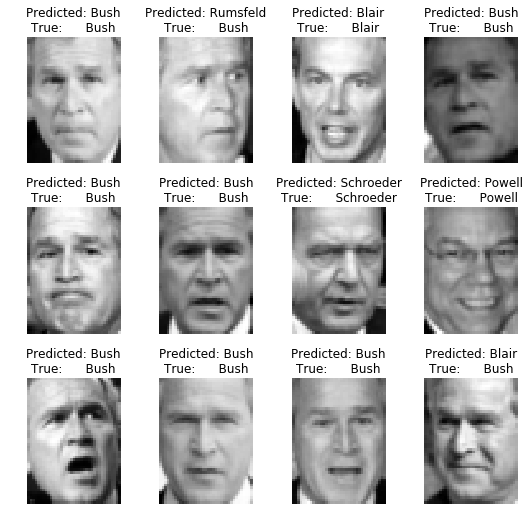

In [12]:
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

<div class = "alert alert-info" style = "background-color:Wheat;border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;">
    


**How many dimensions are we obtaining in the new space? Why?**

We are getting 6 dimensions, since n_classes - 1 = 7 - 1 = 6. By design, LDA reduces the dimensionality of the data to number of classes minus 1. At least in LDA, by discriminants we mean the axes that differentiate more strongly the classes. With C classes, we get C centroids. C centroids of C dimensions define a hyperplane of dimensionality C - 1 (eg. 3 3-D points define a plane).

**Comment the results and compare them with the ones obtained with PCA.**

Generally, the results are considerably worse than before, with an accuracy of 70% (vs 86%) and way lower F1-scores. Still, the rule we said before that classes with more occurences get better results still hold, and the results are way better than a constant or random classifier, so the model can still be useful, but less than before.

The results are worse than in PCA for some reasons. First of all, in the case of PCA, the model itself was a SVM with a radial basis function kernel, which is a non-linear model with high capacity. Now, we are using LDA itself as the classifier (since it can work both as a dimensionality reduction algorithm and classifier), which is linear and is not that expressive.

In addition, we can observe that LDA has reduced to the data to way less dimensions than in the case of PCA, so it could be the case that we have lost information.

Finally, as we will outline in the following section, LDA can obtain bad results if the dataset is imbalanced, as in our case.

**Explain which is the main difference between the two approaches**

Both LDA and PCA are linear transformation techniques that can be used for dimensionality reduction. LDA is supervised (needs true labels) whereas PCA is unsupervised. Each one tries to:

- *PCA:* Find directions of new axis with maximal variance in the data.
- *LDA:* Find feature subspace that maximizes class separability.

<img style="width: 60%" src="https://sebastianraschka.com/images/blog/2014/linear-discriminant-analysis/lda_1.png">

<b>(Image Source: <a href="https://sebastianraschka.com/Articles/2014_python_lda.html">Linear Discriminant Analysis, Sebastian Raschka, Aug 3, 2014</a>)</b>

As LDA makes assumptions about normally distributed classes and equal class covariances, PCA tends to result in better classification results in an image recognition task if the number of samples for a given class is relatively small, such as our problem.

</div>